# Приоритизация гипотез и проведение A/B-теста для интернет-магазина

Анализ гипотез для увеличения выручки крупного интернет-магазина на основе имеющихся данных. 

**Цель исследования:** приоритизировать имеющиеся гипотезы, провести A/B-тест.

Данные о гипотезах представлены файлом `hypothesis.csv`, состоящего из следующих полей (параметров):
+ `Reach` -  оценка охвата пользователей, которых затронет изменение,
+ `Impact` - оценка влияния на пользовательский опыт,
+ `Confidence` - уверенность во влиянии изменений,
+ `Efforts` - оценка ресурсов, необходимых для тестирования гипотезы

Данные о заказах (id заказа, id пользователя, дата, выручка, группа A/B-теста) хранятся в файле `orders.csv`. Данные о количестве пользователей взяты из файла `visitors.csv`.



Исследование будет проводиться по следующему плану: импорт необходимых библиотек и данных, приоритизация гипотез (методом ICE и методом RICE), анализ A/B-теста (анализ графиков кумулятивных метрик, анализ выбросов, применение статистических тест, формулировка выводов).

## Импорт библиотек и загрузка данных

Импортируем необходимые для дальнейшей работы библиотеки.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,5)
from scipy import stats as st
import numpy as np

Загружаем датасеты

In [7]:
hypothesis = pd.read_csv('D:/Project/AB/hypothesis.csv')
orders = pd.read_csv('D:/Project/AB/orders.csv')
visitors = pd.read_csv('D:/Project/AB/visitors.csv')

Посмотрим содержимое датасетов.

In [9]:
pd.options.display.max_colwidth = 1
hypothesis.head(9)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [10]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Столбец с датой и временем представлен текстовым типом данным. Изменим тип данных на соответствующий.

In [13]:
visitors['date'] = visitors['date'].astype('datetime64[ns]')

In [14]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим уникальные значения столбца с названиями группы A/B-теста.

In [16]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

In [17]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Столбец с датой и временем представлен текстовым типом данным. Изменим тип данных на соответствующий.

In [20]:
orders['date'] = orders['date'].astype('datetime64[ns]')

Проверим есть ли в таблице orders пользователи, оказавшиеся одновременно в двух группах.

Сделаем это, разделив таблицу по группам, а затем снова соединив по id пользователя методом inner join. Если в таблице не будет пользователей, которые находятся в двух группах одновременно, то и соединяться будет нечему. В противном случае - таблицы соединятся по id пользователей, которые есть в обеих группах.

In [22]:
ordersA = orders[orders['group']=='A']
ordersB = orders[orders['group']=='B']

In [23]:
orders_merged = ordersA.merge(ordersB,how = 'inner', on = 'visitorId')
# создаем список id, которые есть в обеих группах
AB_ids = orders_merged['visitorId'].drop_duplicates()

In [24]:
print(f'В таблице orders {len(AB_ids)} пользователей, входящих в обе группы теста.')

В таблице orders 58 пользователей, входящих в обе группы теста.


Исключаем этих пользователей из анализа.

In [26]:
orders = orders.query('visitorId not in @AB_ids')

In [27]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


Пользователи, оказавшиеся в 2-х группах исключены из анализа.

## Приоритизация гипотез

Приоритизируем гипотезы методом ICE.

Создадим новый столбец в датафрейме с гипотезами, где будет храниться итоговое количество баллов.

In [32]:
hypothesis['ICE_score'] = round(hypothesis['Impact'] * hypothesis['Confidence'] / hypothesis['Efforts'],3)

In [33]:
# сортируем по убыванию
hypothesis[['Hypothesis','ICE_score']].sort_values(by='ICE_score', ascending = False)

,Hypothesis,ICE_score
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


Наиболее приоритетными оказались восьмая, нулевая и седьмая гипотезы.

Проведем приоритизацию методом RICE.

In [36]:
hypothesis['RICE_score'] = hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']/hypothesis['Efforts']
hypothesis[['Hypothesis','RICE_score']].sort_values(by='RICE_score', ascending = False)

,Hypothesis,RICE_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Приоритизация гипотез меняется в зависимости от фреймворка. Например, самая приоритетная гипотеза в ICE опускается в середину таблицы в RICE. Тем временем в RICE лидирует гипотеза, которая была на третьем месте в ICE, а второе место занимает гипотеза, которая была на пятом месте.

Изменения связаны с параметром Reach (охват пользователей). Фреймворк RICE его учитывает, поэтому гипотеза с параметром reach равным 10 заняла первое место в RICE, а гипотеза с reach равным 1 опустилась с первого места на пятое.

## Анализ A/B-теста

Создадим график кумулятивной выручки по группам. Для этого сначала создадим датафрейм с кумулятивными данными.

In [40]:
# массив уникальных пар дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [41]:
# кумулятивные аггрегированные по дням данные о заказах
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

# кумулятивные аггрегированные по дням данные о посетителях
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одну таблицу
cumulativeData = ordersAggregated.merge(visitorsAggregated,on = ['date','group'])
cumulativeData.columns = ['date','group','orders','buyers','revenue','visitors']

In [42]:
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


Разделим кумулятивные данные по группам A/B-теста.

In [44]:
CumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue','orders']]
CumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue','orders']]

Построим график.

[]

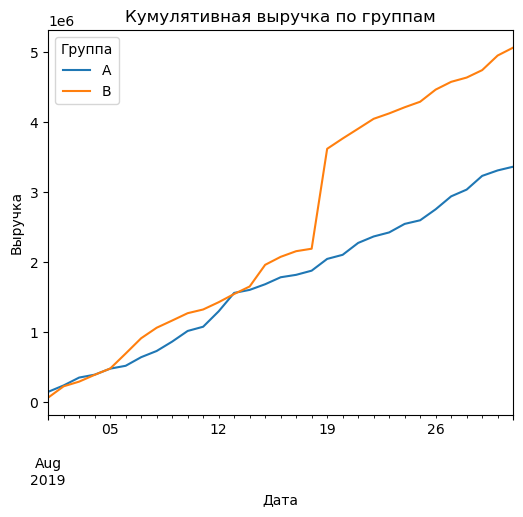

In [46]:
# график кумулятивной выручки группы A сохраняем в переменной "ax"
ax = CumulativeRevenueA.plot(x = 'date', y = 'revenue')
# в параметрах графика кумулятивной выручки группы B указываем "ax=ax", чтобы 2 кривые отображались на одной плоскости
CumulativeRevenueB.plot(ax=ax,x = 'date', y = 'revenue')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend(title = 'Группа', labels = ['A','B'])
plt.plot()

Кумулятивная выручка группы B резко увеличилась в диапазоне дат 17-20 августа, что может свидетельствовать либо о вплесках количества заказов либо о наличии аномально дорогих заказов в выборке. В дальнейшем аномальные заказы из выборки уберем.

Создадим график кумулятивного среднего чека по группам. Для этого разделим кумулятивную выручку на кумулятивное число заказов.

Создадим в датафреймах CumulativeRevenueA и CumulativeRevenueB столбец с кумулятивным средним чеком.

In [50]:
CumulativeRevenueA['avg_bill'] = CumulativeRevenueA['revenue']/CumulativeRevenueA['orders']
CumulativeRevenueB['avg_bill'] = CumulativeRevenueB['revenue']/CumulativeRevenueB['orders']
display(CumulativeRevenueA.head())
display(CumulativeRevenueB.head())

,date,revenue,orders,avg_bill
0,2019-08-01,142779,23,6207.782609
2,2019-08-02,234381,42,5580.500000
4,2019-08-03,346854,66,5255.363636
6,2019-08-04,388030,77,5039.350649
8,2019-08-05,474413,99,4792.050505


,date,revenue,orders,avg_bill
1,2019-08-01,59758,17,3515.176471
3,2019-08-02,221801,40,5545.025000
5,2019-08-03,288850,54,5349.074074
7,2019-08-04,385740,68,5672.647059
9,2019-08-05,475648,89,5344.359551


[]

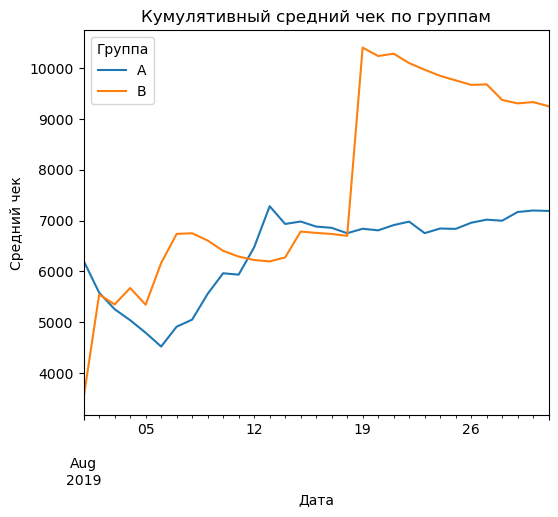

In [51]:
ax = CumulativeRevenueA.plot(x = 'date', y = 'avg_bill')
CumulativeRevenueB.plot(ax=ax,x = 'date', y = 'avg_bill')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend(title = 'Группа', labels = ['A','B'])
plt.plot()

Кумулятивный средний чек группы B также имеет резкий всплеск на тех же датах, что и в кумулятивной выручке. Ранее мною было выказано предположение, что причиной данного всплеска может являться большое количество заказов в эти дни. Однако, в таком случае это бы не повлияло на средний чек. Поэтому скорее всего причиной всплеска являются аномально дорогие покупки в одну из этих дат.

Значения в обоих группах еще не установились около некоторого среднего.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

In [54]:
# объединим между собой таблицы с кумулятивными данными о среднем чеке в каждой группе
MergedCumulativeRevenue = CumulativeRevenueA.merge(CumulativeRevenueB, on = 'date', suffixes = ['A','B'])
# данные о различии среднего чека группы B к группе A вычислим и сохраним в новом столбце
MergedCumulativeRevenue['difference'] = MergedCumulativeRevenue['avg_billB']/MergedCumulativeRevenue['avg_billA'] - 1

Строим график.

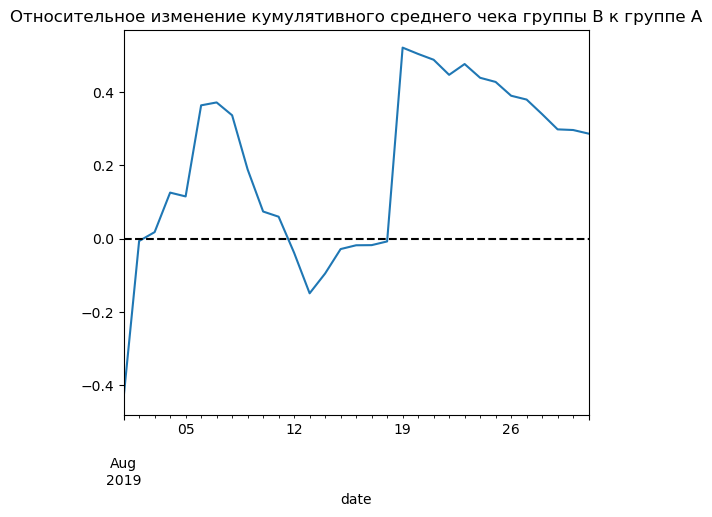

In [56]:
MergedCumulativeRevenue.plot(x = 'date', y = 'difference')
# добавляем горизонтальную линию на значении y=0
plt.axhline(y=0, color='black', linestyle='--') 
# удаляем легенду
plt.legend().remove()
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show()

Снова наблюдаем резкий скачок в районе 17-20 августа.

Построим график кумулятивного среднего количества заказов на посетителя по группам.

In [59]:
#сохраняем данные о среднем количестве заказов на посетттеля в новом столбце
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

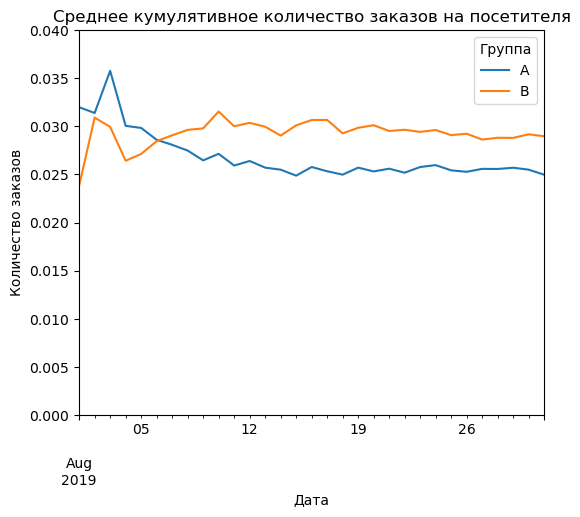

In [60]:
ax = cumulativeDataA.plot(x = 'date',y = 'conversion')
cumulativeDataB.plot(ax=ax, x = 'date',y = 'conversion')
# изменим масштаб осей
plt.ylim(0,0.04)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Среднее кумулятивное количество заказов на посетителя')
plt.legend(title = 'Группа',labels = ['A','B'])
plt.show()

Среднее кумулятивное количество заказов на посетителя зафиксировалось для обоих групп примерно с 11 августа. У группы B это значение немного выше.

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

In [63]:
# объединим датафреймы с данными о кумулятивном среднем количестве заказов на пользователя
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']],on='date', suffixes=['A', 'B'])

In [64]:
# вычислим разницу группы B к группе A и сохраним в отдельном столбце
mergedCumulativeConversions['difference'] = mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1

Строим график.

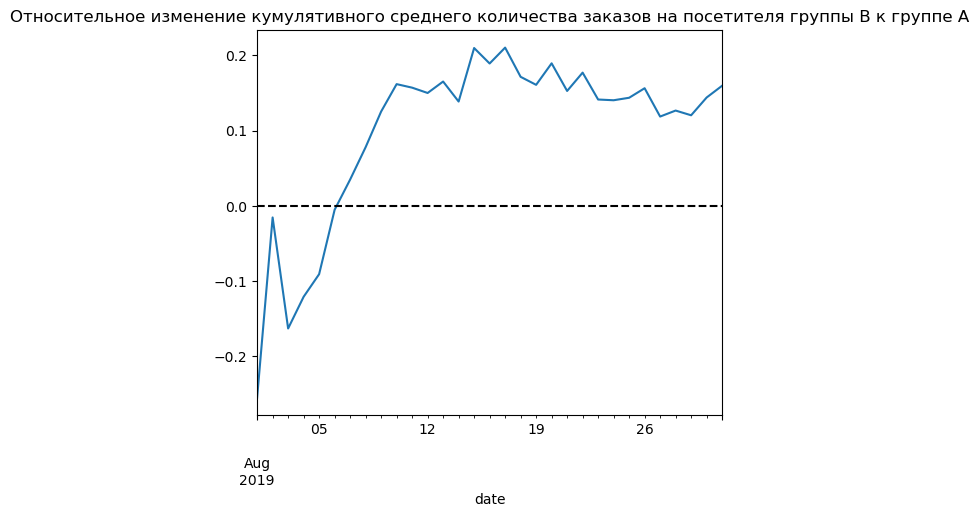

In [66]:
mergedCumulativeConversions.plot(x = 'date',y = 'difference')
plt.axhline(y=0, color='black', linestyle='--') 
plt.legend().remove()
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.show()

Судя по графику, количество заказов на посетителя в группе B выше, чем в группе A.

Построим точечный график количества заказов по пользователям. Для этого сначала создадим переменную, в которой будет аггрегировано количество уникальных заказов для каждого пользователя.

In [69]:
OrdersByUsers = orders.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'})
OrdersByUsers.columns = ['userId', 'orders']

Также перед созданием графика необходимо сгенерировать значения x в виде объекта Series от 0 до n, где n - количество пользователей.

In [71]:
x_values = pd.Series(range(0,len(OrdersByUsers)))

Создаем график.

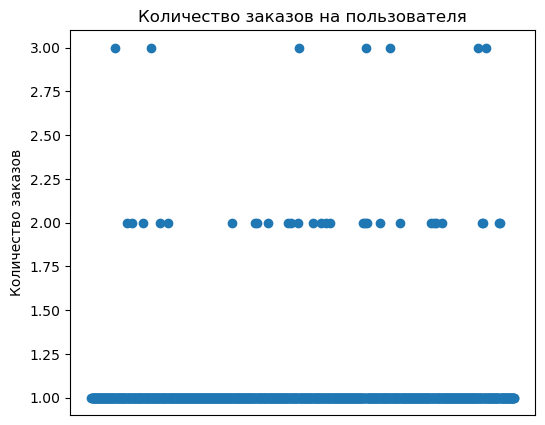

In [73]:
# убираем обозначения оси X, т.к. они не имеют практического значения. По сути это просто порядковый номер пользователя
plt.xticks([])
plt.scatter(x_values, OrdersByUsers['orders'])
plt.title('Количество заказов на пользователя')
plt.ylabel('Количество заказов')
plt.show()

Пользователи совершали в основном по 1 заказу, также есть пользователи с 2-3 заказами.

Построим точечный график стоимостей заказов.

In [76]:
x_values = pd.Series(range(0,len(orders)))

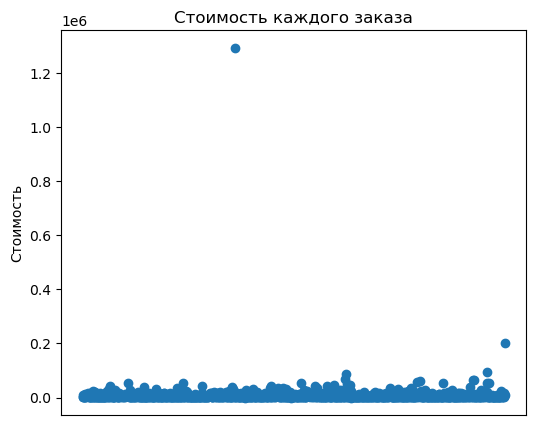

In [77]:
plt.xticks([])
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость')
plt.title('Стоимость каждого заказа')
plt.show()

В данных есть явный выброс в виде заказа стоимостью более 1,2 млн рублей.

Посчитаем 95 и 99 перцентили стоимости заказов. Определим границу аномальных заказов.

In [80]:
np.percentile(orders['revenue'],[95,99])

array([26785., 53904.])

Стоимость 95% заказов составляет не более 26785 рублей, а стоимость 99% заказов - не более 53904 рублей.

По полученному выше графику сложно определиться с границей аномально дорогих заказов, т.к. на нем слишком большой масштаб оси Y. Посмотрим тот же график, но с границами оси Y от 0 до 100000.

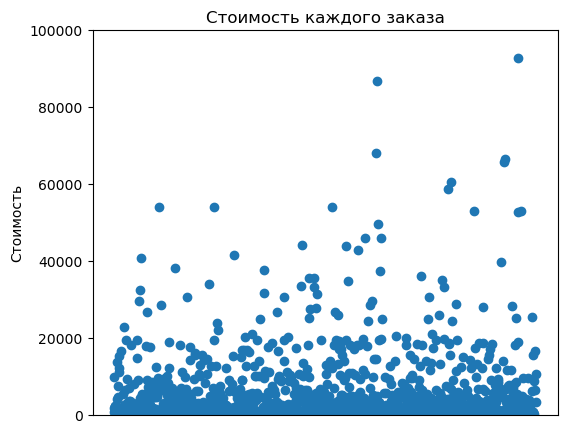

In [82]:
plt.xticks([])
plt.scatter(x_values, orders['revenue'])
plt.ylabel('Стоимость')
plt.title('Стоимость каждого заказа')
plt.ylim(0,100000)
plt.show()

Определим аномально дорогие заказы, как заказы стоимостью более 60000 тыс. рублей.

In [84]:
UsersWithExpensiveOrders = orders[orders['revenue']>=60000]['visitorId']

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Создадим переменные OrdersByUsersA и OrdersByUsersB, в которых для всех пользователей, сделавших хотя бы 1 заказ, будет указано количество заказов.

In [87]:
OrdersByUsersA = orders[orders['group']=='A'].groupby('visitorId',as_index = False).agg({'transactionId':pd.Series.nunique})
OrdersByUsersA.columns = ['userId','orders']
OrdersByUsersB = orders[orders['group']=='B'].groupby('visitorId',as_index = False).agg({'transactionId':pd.Series.nunique})
OrdersByUsersB.columns = ['userId','orders']

Создадим переменные SampleA и SampleB, куда войдет количество покупок каждого пользователя, в т.ч. и тех, кто не совершил ни одной покупки.

Количество пользователей без покупок равно разнице между суммой посетителей и количеством записей о заказах. Для краткости кода создадим переменные с количеством пользователей без покупок для каждой группы.

In [90]:
UsersWithZeroOrdersA = visitors[visitors['group']=='A']['visitors'].sum() - len(OrdersByUsersA)
UsersWithZeroOrdersB = visitors[visitors['group']=='B']['visitors'].sum() - len(OrdersByUsersB)

In [91]:
SampleA = pd.concat([OrdersByUsersA['orders'],pd.Series(0,index=np.arange(UsersWithZeroOrdersA),name = 'orders')],axis = 0)
SampleB = pd.concat([OrdersByUsersB['orders'],pd.Series(0,index=np.arange(UsersWithZeroOrdersB),name = 'orders')],axis = 0)

Посчитаем есть ли статистическое различие количества средних заказов между группами с помощью непараметрического теста Уилкоксона-Манна-Уитни, т.к. работаем с данными с выбросами.

Определим гипотезы.

Нулевая гипотеза: различий между группами в среднем количестве заказов на пользователя нет.

Альтернативная гипотеза: существуют различие между группами в среднем количестве заказов.

In [93]:
#установим уровень статистической значимости равной 5%
alpha = 0.05
results = st.mannwhitneyu(SampleA,SampleB)
print(f'p-value равно {round(results.pvalue,3)}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница между группами статистически значима')
else:
    print('Не отвергаем нулевую гипотезу: вывод о различии между группами сделать нельзя')

p-value равно 0.011
Отвергаем нулевую гипотезу: разница между группами статистически значима


Выведем относительный прирост группы B

In [95]:
print(f'Относительный прирост группы B составляет {round((SampleB.mean()/SampleA.mean() - 1) * 100)}%')

Относительный прирост группы B составляет 16%


На сырых данных гипотеза о равенстве количества заказов между двумя группами пользователей отвергается.


Проверим статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Снова применим тест Уилкоксона-Манна-Уитни.

Нулевая гипотеза: различий в среднем чеке между группами нет.

Альтернативная гипотеза: существуют различия в среднем чеке между группами.

In [98]:
#уровень статистической значимости оставим на уровне 5%. Это значение уже сохранено в переменной alpha
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'],orders[orders['group']=='B']['revenue'])
print(f'p-value равно {round(results[1],3)}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница между группами статистически значима')
else:
    print('Не отвергаем нулевую гипотезу: вывод о различии между группами сделать нельзя')

p-value равно 0.829
Не отвергаем нулевую гипотезу: вывод о различии между группами сделать нельзя


Выведем относительный прирост группы B.

In [100]:
up = (orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1) * 100
print(f'Прирост группы B относительно группы A составляет {round(up,2)}%')

Прирост группы B относительно группы A составляет 28.66%


У группы B высокий прирост относительно группы A. Возможно это из-за выбросов в данных.

По сырым данным нет статистического значимого различия между средними чеками в разных группах.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Сохраним всех аномальных пользователей в переменной AbnormalUsers.

In [105]:
AbnormalUsers = UsersWithExpensiveOrders.drop_duplicates().sort_values()

Исключим из переменных SampleA и SampleB аномальные данные.

In [107]:
SampleAfiltered = pd.concat([OrdersByUsersA[np.logical_not(OrdersByUsersA['userId'].isin(AbnormalUsers))]\
['orders'],pd.Series(0,index=np.arange(UsersWithZeroOrdersA),name = 'orders')],axis=0)
SampleBfiltered = pd.concat([OrdersByUsersB[np.logical_not(OrdersByUsersB['userId'].isin(AbnormalUsers))]\
['orders'],pd.Series(0,index=np.arange(UsersWithZeroOrdersB),name = 'orders')],axis=0)

Проверим получилось ли отфильтровать данные. Сравним длину переменных до и после фильтрации.

In [109]:
print(len(SampleA),len(SampleAfiltered))
print(len(SampleB),len(SampleBfiltered))

18736 18731
18916 18913


Фильтрация прошла успешно.

Применим критерий Манна-Уитни к полученным выборкам.

In [112]:
results = st.mannwhitneyu(SampleAfiltered,SampleBfiltered)
print(f'p-value равно {round(results.pvalue,3)}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница между группами статистически значима')
else:
    print('Не отвергаем нулевую гипотезу: вывод о различии между группами сделать нельзя')

p-value равно 0.009
Отвергаем нулевую гипотезу: разница между группами статистически значима


Выведем относительный прирост группы B

In [114]:
up = (SampleBfiltered.mean()/SampleAfiltered.mean() - 1) * 100
print(f'Прирост группы B относительно группы A составил {round(up,2)}%')

Прирост группы B относительно группы A составил 16.58%


P-value в очищенных данных стал немного ниже, но сути это не меняет: у групп статистически значимая разница по количеству заказов.

Относительный прирост группы B стал немного выше на очищенных данных.

Проверим статистическую значимость различий в среднем чеке в зависимости от группы теста.

Сохраним отфильтрованные данные о чеках в каждой группе в переменных FilteredRevenueA и FilteredRevenueB.

In [119]:
FilteredRevenueA = orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(AbnormalUsers)),)]['revenue']
FilteredRevenueB = orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(AbnormalUsers)),)]['revenue']

Применим критерий Манна-Уитни к полученным выборкам. Сформулируем гипотезы.

Нулевая гипотеза: разницы между средними чеками между группами нет.

Альтернативная гипотеза: есть статистически значимая разница средних чеков между группами.

In [121]:
results = st.mannwhitneyu(FilteredRevenueA,FilteredRevenueB)
print(f'p-value равно {round(results[1],3)}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница между группами статистически значима')
else:
    print('Не отвергаем нулевую гипотезу: вывод о различии между группами сделать нельзя')

p-value равно 0.941
Не отвергаем нулевую гипотезу: вывод о различии между группами сделать нельзя


Выведем относительный прирост группы B.

In [123]:
up = (FilteredRevenueB.mean()/FilteredRevenueA.mean()-1) * 100
print(f'Относительный прирост группы B составляет {round(up,2)}%')

Относительный прирост группы B составляет -1.69%


После фильтрации данных разница между сегментами стала незначительной.

P-value после очистки данных стал еще выше, чем был, но вывод остается тем же: между группами нет статистически значимой разницы по среднему чеку.

### Выводы по A/B-тесту.

По количеству заказов имеется статистически значимая разница между группами по сырым и обработанным данным. По средним чекам A/B-тест показал отсутствие статистически значимой разницы между группами, как по сырым данным, так и по отфильтрованным.
    
Тест можно завершать, выручка компании должна увеличиться в следствие увеличения количества заказов у группы B.

## Общие выводы

Нами была проведена предобработка данных. Из анализа были исключены пользователи, которые попали в две группы одновременно.

Была проведена приоритизация гипотез методологиями ICE и RICE. Выбор гипотезы зависит от того, насколько в интернет-магазине важен такой параметр Reach.
    
Был проведен A/B-тест. В ходе него выяснили, что у группы B большее среднее количество заказов на пользователя, чем у группы A.